In [1]:
from qiskit import QuantumCircuit, execute
from qiskit import IBMQ, Aer
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel
import qiskit.providers.aer.noise as noise


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [89]:
# Build noise model from backend properties
#provider = IBMQ.load_account()
#backend = provider.get_backend('ibmq_vigo')
backend = Aer.get_backend("qasm_simulator")
#noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
#coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model

noise_model = noise.NoiseModel()

# Make a circuit
circ = QuantumCircuit(3, 3)

# Noisy rotation
# Perfect CNOT
# Noisy measure

# circ.h(0)
# circ.h(1)
# circ.h(2)

circ.x(0)

#circ.cx(0, 1)
#circ.cx(1, 2)

circ.measure([0, 1, 2], [0, 1, 2])

# Perform a noise simulation
result = execute(circ,
                 Aer.get_backend('qasm_simulator'),
                 noise_model=noise_model,
                 shots=100000).result()
counts = result.get_counts(0)


In [408]:
for line in probs:
    for val in line:
        print("%.2f " % val, end='')
    print()

0.35 0.05 0.05 0.15 0.05 0.15 0.15 0.05 
0.02 0.38 0.15 0.05 0.15 0.05 0.03 0.16 
0.02 0.15 0.38 0.05 0.15 0.03 0.05 0.16 
0.14 0.02 0.02 0.41 0.04 0.16 0.16 0.06 
0.02 0.15 0.15 0.03 0.38 0.05 0.05 0.16 
0.14 0.02 0.04 0.16 0.02 0.41 0.16 0.06 
0.14 0.04 0.02 0.16 0.02 0.16 0.41 0.06 
0.02 0.16 0.16 0.02 0.16 0.02 0.02 0.44 


In [409]:
n_qubits = 3
probs = gen_error_probs(
        [100,10,40,1], # Const - Controls correlation of error weights
        [0, 4,3,3], # 1 -> 0 - Controls error biases
        [0,-5,-5,-5] # 0 -> 1 - Controls error biases
        )

# for line in probs:
#     for entry in line:
#         print("%.2f" % entry, end='')
#     print()

counts_final = noisy_measure(counts, probs=probs)

# plt.plot(list(i / sum(counts.values()) for i in counts.values()))
# plt.plot(list(i / sum(counts_final.values()) for i in counts_final.values()))

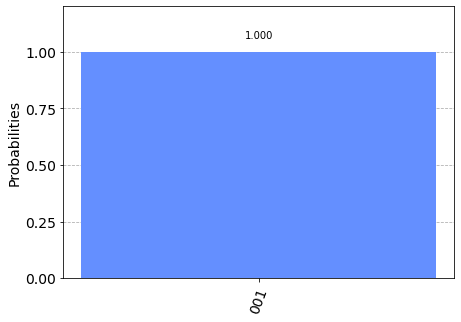

In [410]:
plot_histogram(counts)

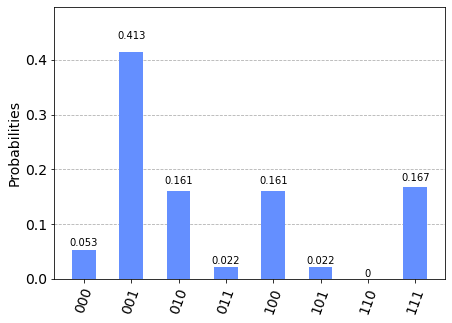

In [411]:
plot_histogram(counts_final)

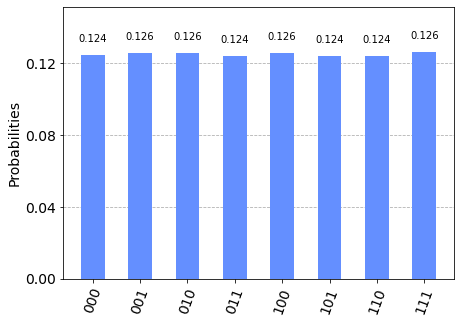

In [407]:
for i in range(2):
    counts_final = noisy_measure(counts_final, probs=probs)
plot_histogram(counts_final)

In [363]:
def noisy_measure(counts, probs=np.array(gen_error_probs(
        [0,3,3,1000], # Const
        [0,1,2,3], # 0 -> 1
        [0,9,16,25] # 1 -> 0
        )),
        n_qubits=3):
    
    #print(probs)

    vec = np.zeros((2 ** n_qubits, 1))

    for i in range(2 ** n_qubits):
        try:
            vec[i][0] = counts[str(bin(i)[2:].zfill(n_qubits))]
        except:
            pass

    err_counts = list(map(round, list((probs @ vec).flatten())))
    
    counts_final = {}
    for i in range(2 ** n_qubits):
        i_str = bin(i)[2:].zfill(n_qubits)
        counts_final[i_str] = err_counts[i] 

    return counts_final

In [262]:
def gen_error_probs(error_arr_c, error_arr_u, error_arr_d, n_qubits = 3, s_penalty=0.3):

    probs = [[0] * (2 ** n_qubits) for _ in range(2 ** n_qubits)]
    
    if len(error_arr_c) != n_qubits + 1:
        raise Exception("Incorrect Error Array")
    
    
    if len(error_arr_u) != n_qubits + 1:
        raise Exception("Incorrect Error Array")
        
        
    if len(error_arr_d) != n_qubits + 1:
        raise Exception("Incorrect Error Array")
    
    for row in range(2 ** n_qubits):
        row_str = bin(row)[2:].zfill(n_qubits)


        for col in range(2 ** n_qubits):
            col_str = bin(col)[2:].zfill(n_qubits)

            diff_str = [i - j for i, j in zip(list(map(int, row_str)), list(map(int, col_str)))]   
            
            #probs[row][col] -= s_penalty * sum(1 if i == 1 else 0 for i in row_str)
            
            probs[row][col] += error_arr_u[sum(1 if i == -1 else 0 for i in diff_str)]
            probs[row][col] += error_arr_d[sum(1 if i == 1 else 0 for i in diff_str)]
            probs[row][col] += error_arr_c[n_qubits - sum(1 if i == 0 else 0 for i in diff_str)]
            
            probs[row][col] = max(0, probs[row][col])
            
            #print(diff_str)
            
#             print(col_str, row_str, diff_str)
        
    #Normalise rows, we can then do arbitrary scaling factors in the error arr
    for row, _ in enumerate(probs):
        np_row = np.array(probs[row])
        if sum(np_row) > 0:
            np_row = np_row / sum(np_row) 
        probs[row] = list(np_row)
    
    return probs
#     print(probs)

In [8]:
probs = gen_error_probs(
    [0,1,1,200], # Const
    [0,1,2,3], # 0 -> 1
    [0,4,9,16]) # 1 -> 0

for line in probs:
    for val in line:
        print("%.2f " % (val), end='')
    print()

0.92 0.01 0.01 0.01 0.01 0.01 0.01 0.01 
0.02 0.87 0.03 0.01 0.03 0.01 0.03 0.01 
0.02 0.03 0.87 0.01 0.03 0.03 0.01 0.01 
0.04 0.02 0.02 0.82 0.04 0.02 0.02 0.01 
0.02 0.03 0.03 0.03 0.87 0.01 0.01 0.01 
0.04 0.02 0.04 0.02 0.02 0.82 0.02 0.01 
0.04 0.04 0.02 0.02 0.02 0.02 0.82 0.01 
0.06 0.04 0.04 0.02 0.04 0.02 0.02 0.77 


In [166]:
probs = gen_error_probs(
    [0,3,200], # Const
    [0,1,2], # 0 -> 1
    [0,4,9], # 1 -> 0
n_qubits=2)

for line in probs:
    for val in line:
        print("%.2f " % (val), end='')
    print()

0.95 0.02 0.02 0.01 
0.03 0.93 0.02 0.02 
0.03 0.02 0.93 0.02 
0.04 0.03 0.03 0.90 
